In [3]:
!pip install kagglehub tensorflow matplotlib seaborn scikit-learn pillow

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import json
from PIL import Image
import kagglehub

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shubhamgoel27/dermnet")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dermnet' dataset.
Path to dataset files: /kaggle/input/dermnet


#Check dataset

In [6]:
def explore_directory_structure_detailed(base_path):
    print(f"\nKHÁM PHÁ CHI TIẾT CẤU TRÚC THƯ MỤC: {base_path}")

    if not os.path.exists(base_path):
        print("Thư mục không tồn tại")
        return

    print("\nCấu trúc thư mục (2 level đầu tiên):")
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, '').count(os.sep)
        if level <= 2:  # Chỉ hiển thị 2 level đầu
            indent = '  ' * level
            print(f'{indent} {os.path.basename(root)}/')

            # Hiển thị thư mục con
            sub_indent = '  ' * (level + 1)
            for dir_name in dirs[:10]:
                print(f'{sub_indent} {dir_name}/')
            if len(dirs) > 10:
                print(f'{sub_indent}... và {len(dirs) - 10} thư mục khác')

            # Hiển thị file
            for file_name in files[:5]:
                print(f'{sub_indent} {file_name}')
            if len(files) > 5:
                print(f'{sub_indent}... và {len(files) - 5} file khác')
            print()  # Xuống dòng giữa các thư mục
# Khám phá chi tiết
explore_directory_structure_detailed(path)
def find_data_directories(base_path):
    """Tìm tất cả các thư mục có thể chứa dữ liệu train/test"""
    possible_train_dirs = []
    possible_test_dirs = []

    for root, dirs, files in os.walk(base_path):
        # Kiểm tra nếu thư mục có vẻ chứa dữ liệu ảnh
        if any(keyword in root.lower() for keyword in ['train', 'training']):
            possible_train_dirs.append(root)
        elif any(keyword in root.lower() for keyword in ['test', 'testing', 'val', 'validation']):
            possible_test_dirs.append(root)

        # Kiểm tra nếu thư mục có nhiều thư mục con (có thể là classes)
        if len(dirs) > 5:
            print(f"Thư mục có nhiều lớp tiềm năng: {root} ({len(dirs)} thư mục con)")

    return possible_train_dirs, possible_test_dirs

print("\nĐang tìm thư mục dữ liệu...")
possible_train_dirs, possible_test_dirs = find_data_directories(path)

print(f"\nCác thư mục train tiềm năng:")
for dir_path in possible_train_dirs[:5]:
    print(f"  - {dir_path}")

print(f"\nCác thư mục test tiềm năng:")
for dir_path in possible_test_dirs[:5]:
    print(f"  - {dir_path}")
dermnet_path = os.path.join(path, 'dermnet')
if os.path.exists(dermnet_path):
    print(f"\n Kiểm tra thư mục 'dermnet': {dermnet_path}")
    explore_directory_structure_detailed(dermnet_path)


KHÁM PHÁ CHI TIẾT CẤU TRÚC THƯ MỤC: /kaggle/input/dermnet

Cấu trúc thư mục (2 level đầu tiên):
 dermnet/
   test/
   train/

   test/
     Light Diseases and Disorders of Pigmentation/
     Lupus and other Connective Tissue diseases/
     Acne and Rosacea Photos/
     Systemic Disease/
     Poison Ivy Photos and other Contact Dermatitis/
     Vascular Tumors/
     Urticaria Hives/
     Atopic Dermatitis Photos/
     Bullous Disease Photos/
     Hair Loss Photos Alopecia and other Hair Diseases/
    ... và 13 thư mục khác

     Light Diseases and Disorders of Pigmentation/
      📄 polymorphous-light-eruption-33.jpg
      📄 milia-11.jpg
      📄 pseudo-porphyria-2.jpg
      📄 sun-damaged-skin-12.jpg
      📄 phototoxic-reactions-72.jpg
      ... và 138 file khác

     Lupus and other Connective Tissue diseases/
      📄 crest-syndrome-12.jpg
      📄 rheumatoid-nodule-8.jpg
      📄 lupus-acute-24.jpg
      📄 morphea-96.jpg
      📄 rheumatoid-nodule-9.jpg
      ... và 100 file khác

     Ac

#Path final

In [7]:
def find_correct_paths(base_path):
    """Tìm đường dẫn chính xác cho train và test data"""

    # Các pattern có thể
    patterns = [

        {'train': ['train'], 'test': ['test']},

        {'train': ['train'], 'test': ['test', 'valid', 'validation']},

        {'train': ['data', 'train'], 'test': ['data', 'test']},
    ]

    for pattern in patterns:
        train_candidates = pattern['train']
        test_candidates = pattern['test']

        for train_candidate in train_candidates:
            for test_candidate in test_candidates:
                train_path = base_path
                test_path = base_path

                # Thử các combination
                for part in train_candidate.split('/'):
                    train_path = os.path.join(train_path, part)
                for part in test_candidate.split('/'):
                    test_path = os.path.join(test_path, part)

                if os.path.exists(train_path) and os.path.exists(test_path):
                    # Kiểm tra xem có chứa thư mục con không (classes)
                    train_subdirs = [d for d in os.listdir(train_path)
                                   if os.path.isdir(os.path.join(train_path, d))]
                    test_subdirs = [d for d in os.listdir(test_path)
                                  if os.path.isdir(os.path.join(test_path, d))]

                    if len(train_subdirs) > 0 and len(test_subdirs) > 0:
                        print(f" Tìm thấy cấu trúc phù hợp!")
                        print(f"   Train: {train_path} ({len(train_subdirs)} classes)")
                        print(f"   Test: {test_path} ({len(test_subdirs)} classes)")
                        return train_path, test_path

    # Nếu không tìm thấy bằng pattern, thử tìm thủ công
    print("\nTìm kiếm thủ công...")
    for root, dirs, files in os.walk(base_path):
        if len(dirs) > 10:
            print(f"Thư mục có {len(dirs)} lớp: {root}")
            parent_dir = os.path.dirname(root)
            sibling_dirs = [d for d in os.listdir(parent_dir)
                          if os.path.isdir(os.path.join(parent_dir, d))] if parent_dir != base_path else []

            if len(sibling_dirs) >= 2:
                print(f"   Các thư mục cùng cấp: {sibling_dirs}")

    return None, None

print("\n Đang tìm đường dẫn chính xác...")
train_path, test_path = find_correct_paths(path)
if train_path is None:
    print("\nThử đường dẫn trực tiếp...")
    direct_paths = [
        path,
        os.path.join(path, 'dermnet'),
        os.path.join(path, 'data'),
        os.path.join(path, 'DermNet'),
    ]

    for base in direct_paths:
        if os.path.exists(base):
            items = os.listdir(base)
            print(f"Nội dung của {base}:")
            for item in items:
                item_path = os.path.join(base, item)
                if os.path.isdir(item_path):
                    num_subitems = len(os.listdir(item_path))
                    print(f"{item}/ ({num_subitems} items)")
                else:
                    print(f"{item}")
            print()


 Đang tìm đường dẫn chính xác...
 Tìm thấy cấu trúc phù hợp!
   Train: /kaggle/input/dermnet/train (23 classes)
   Test: /kaggle/input/dermnet/test (23 classes)


In [8]:
# Lấy danh sách class names
class_names = sorted([d for d in os.listdir(train_path)
                     if os.path.isdir(os.path.join(train_path, d))])
NUM_CLASSES = len(class_names)  #số nhãn

print(f"\nTHÔNG TIN DATASET:")
print(f"   Số lớp: {NUM_CLASSES}")
print(f"   Danh sách lớp: {class_names}")


print(f"\nSỐ LƯỢNG ẢNH TRONG MỖI LỚP:")
total_train = 0
total_test = 0

for class_name in class_names:
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)

    train_count = len([f for f in os.listdir(train_class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    test_count = len([f for f in os.listdir(test_class_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    total_train += train_count
    total_test += test_count
    print(f"   {class_name:25s} | Train: {train_count:4d} | Test: {test_count:4d}")

print(f"   {'TOTAL':25s} | Train: {total_train:4d} | Test: {total_test:4d}")


THÔNG TIN DATASET:
   Số lớp: 23
   Danh sách lớp: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']

SỐ LƯỢNG ẢNH TRONG MỖI LỚP:
   Acne a

#Thiếp lập parameters

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

#Chuẩn bị Data Generators


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% cho validation
)


val_test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 12453 images belonging to 23 classes.
Found 3104 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.
Training samples: 12453
Validation samples: 3104
Test samples: 4002


#SHOW IMAGE TRONG DATASET

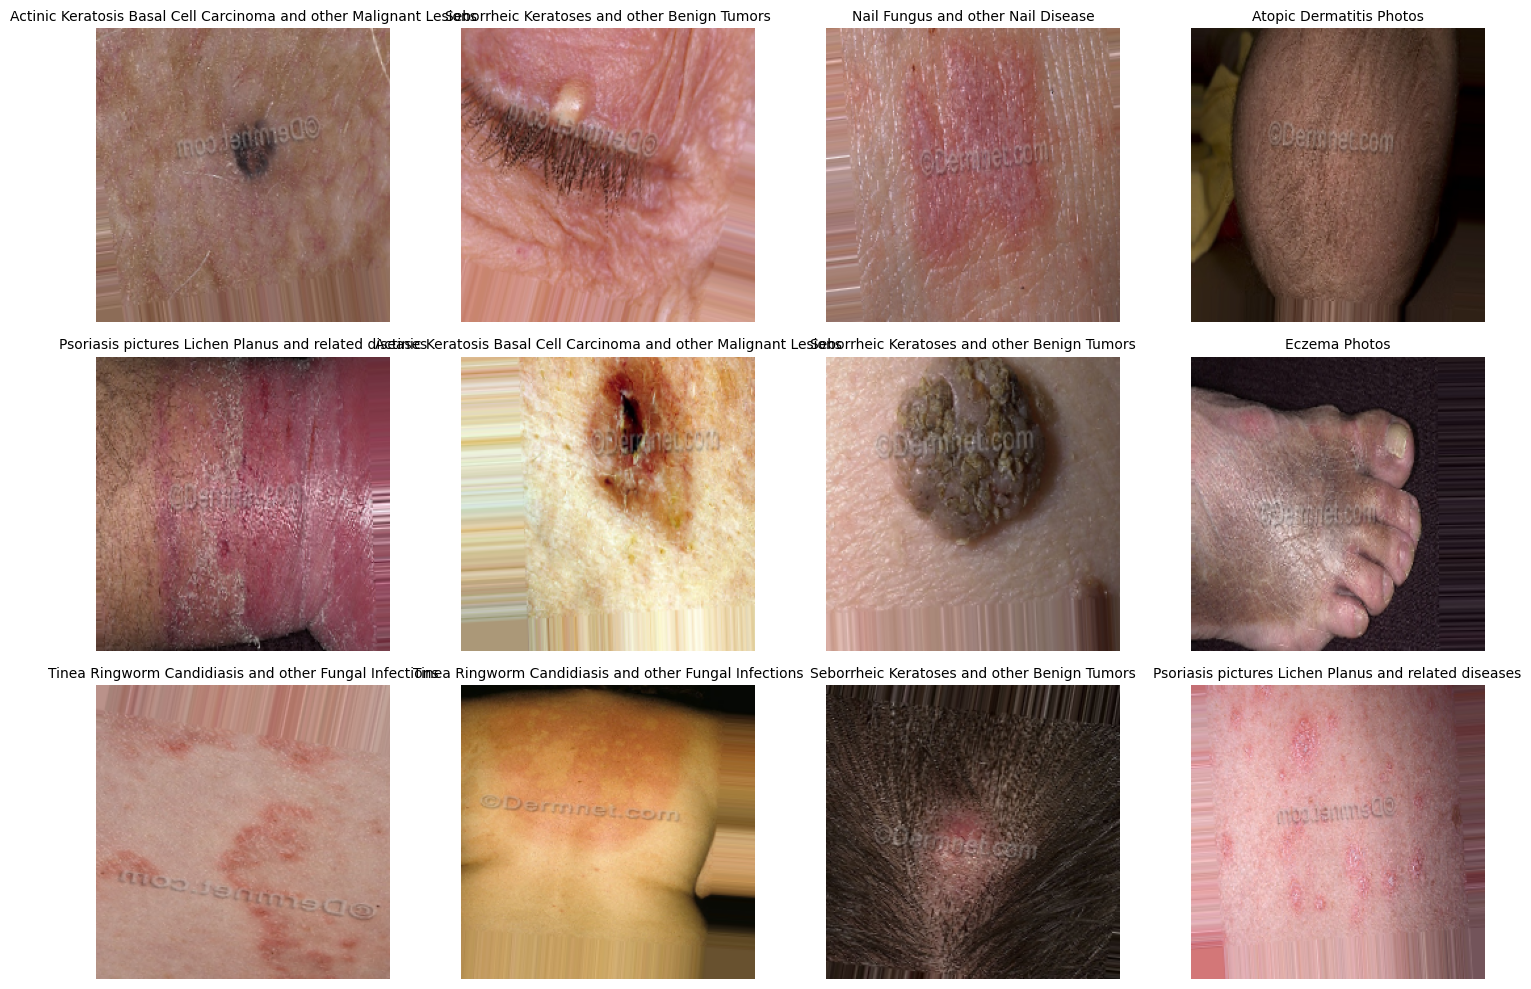

In [11]:
def plot_sample_images(generator, class_names):
    """Hiển thị một số ảnh mẫu từ generator"""
    plt.figure(figsize=(15, 10))

    # Lấy một batch ảnh
    images, labels = next(generator)


    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        plt.title(f'{class_names[label_idx]}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Hiển thị ảnh từ training set
plot_sample_images(train_generator, class_names)

#BUILD MODEL CNN


In [12]:
def create_cnn_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    model = keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape), #32 filter (3x3) -> 2D ,relu(phi tuyến) bỏ âm , same -> tránh mất pixel khi tích chập
        layers.BatchNormalization(),  #Theo lô
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2), #giảm 1/2 size
        layers.Dropout(0.25), #bỏ 25% neuron -> trình overfitting

        # Block 2 -> về block sau tăng filter học sâu
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        # Fully Connected -> Như Deep Learning
        layers.Flatten(), #2D -> 1D
        layers.Dense(512, activation='relu'), #Them 512 neuron
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax') #số loại đầu ra , đầu ra theo xác suất từng lớp
    ])

    return model

# Tạo model
model = create_cnn_model()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Architecture model

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,007,031 (103.02 MB)

 Trainable params: 27,003,575 (103.01 MB)

 Non-trainable params: 3,456 (13.50 KB)

#Callback ngay khi overfitting hoặc không cải thiện được accuracy nữa

In [14]:

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_skin_disease_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

#Thực hiện Train MODEL

In [2]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

NameError: name 'model' is not defined